# Relative strength index (RSI)

In [1]:
import os
setup_script = os.path.join(os.environ['ENV_JUPYTER_SETUPS_DIR'], 'setup_sci_env_basic.py')
%run $setup_script

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_mpl_style('single_plot.mplstyle')
ignore_warnings()

**Relative strength index (RSI)** is defined as:
\begin{equation}
    \text{RSI}
    =
    100
    -
    \frac{100}{1+RS}
\end{equation}

To construct he RSI we need to calculate the relative strength $\text{RS}$, which is:
\begin{equation}
    \text{RS}
    =
    \frac{MA(U,n)}{MA(D,n)}
\end{equation}

$MA(x,n)$ is a moving average function which could be the:
- uniformly weighted moving average:

    \begin{equation}
        UWMA(x,n)
        =
        \frac{\sum_{i} p_{i}}{n}
    \end{equation}
    
    Here $i$ goes over the last $n$ periods inclusive of $x$, that is $x$: $i=x,x-1,x-2,x-(n-1)$.
    
- exponentially weighted moving average:

    \begin{equation}
        EWMA(x,n)
        =
        \frac{\sum_{i} (1-\alpha)^{x-i} p_{i} }{n}
    \end{equation}
    
    Here $i$ goes over the last $n$ periods inclusive of $x$, that is $x$: $i=x,x-1,x-2,x-(n-1)$. The prices are weighted by some power of $(1-\alpha)$, where $\alpha$ is the decay parameter ($0 \leq \alpha < 1$). The latest price, $p_{x}$ receives a full weight of $(1-\alpha)^{x-x}=1$, whereas the price furthest from today the has the smallest weight $(1-\alpha)^{x-[x-(n-1)])} = (1-\alpha)^{n-1}$.

    Some alternative ways to define the decay parameter:
    
    - center of mass:
        \begin{equation}
        \alpha = \frac{1}{1 + \text{center of mass}}
        \end{equation}

    - span:
        \begin{equation}
        \alpha = \frac{2}{1 + \text{span}}
        \end{equation}
    
    - half-life, $\tau_{1/2}$
        \begin{equation}
        \alpha = 1 - \exp\left[\log_{0.5} (\tau_{1/2})\right]
        \end{equation}

The upward change, $U$ and downward change, $D$ are the absolute values of the changes in up and down days:

\begin{equation}
\begin{aligned}
    U
    &=
    \theta(\text{price}_{now} - \text{price}_{previous})
    \\
    D
    &=
    \theta(\text{price}_{previous} - \text{price}_{now})
\end{aligned}
\end{equation}

Note that $U=0$ when there is a down day, and $D=0$ when there is an up day.

- up day: $\text{price}_{now} > \text{price}_{previous}$
- down day: $\text{price}_{now} < \text{price}_{previous}$


References:
- https://en.wikipedia.org/wiki/Relative_strength_index
- https://www.investopedia.com/terms/r/rsi.asp
- http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.ewma.html

Load FTSE100 tickers

In [3]:
ftse100 = pd.read_csv('./ftse100_tickers.dat')

Load and merge price data

In [4]:
df = pd.DataFrame()
for ticker in ftse100['ticker']:
    df_ = pd.read_csv('./data/{}.dat'.format(ticker))
    df_['ticker'] = ticker
    if df.empty:
        df = df_
    else:
        df = df.append(df_)

In [5]:
df.set_index(['ticker', 'Date'], inplace=True)

Selecting a single security and width of the rolling window

In [6]:
security = 'BARC.L'
window = 14

Create an array of the daily price differences:

In [7]:
close = df.loc[security]['Adj Close']
delta = close.diff()

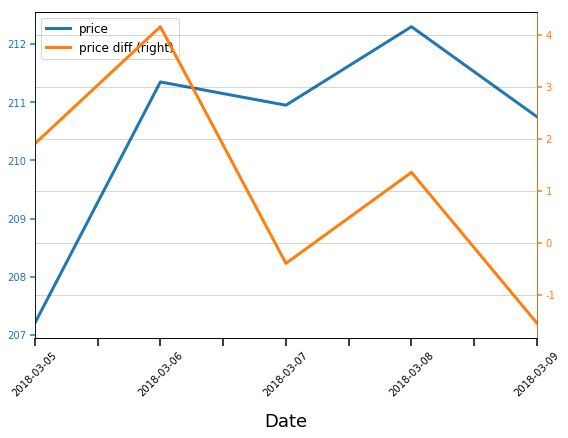

In [8]:
a1 = close[-5:].plot(rot=45, label='price', legend=True)
a2 = delta[-5:].plot(secondary_y=True, rot=45, label='price diff', legend=True)
a1.spines['left'].set_color('C0')
a2.spines['right'].set_color('C1')
a1.tick_params(axis='y', colors='C0')
a2.tick_params(axis='y', colors='C1')

Create the positive gains (up) and negative gains (down)

In [9]:
up, down = delta.copy(), delta.copy()
up[up < 0] = 0 
down[down > 0] = 0 

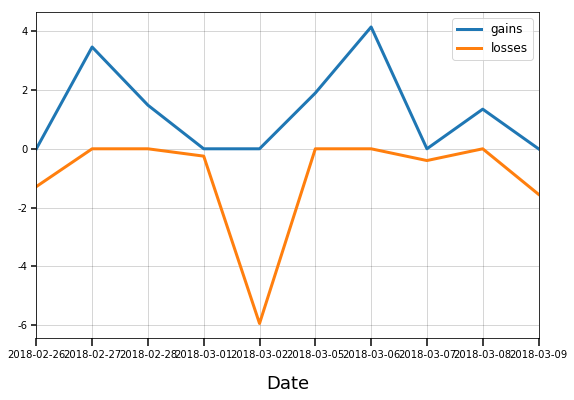

In [10]:
f,a = plt.subplots()
up[-10:].plot(ax=a, label='gains', legend=True)
down[-10:].plot(ax=a, label='losses', legend=True)

Simple moving averages of the gains and losses

In [11]:
roll_up   = pd.rolling_mean(up, window)
roll_down = pd.rolling_mean(down.abs(), window)

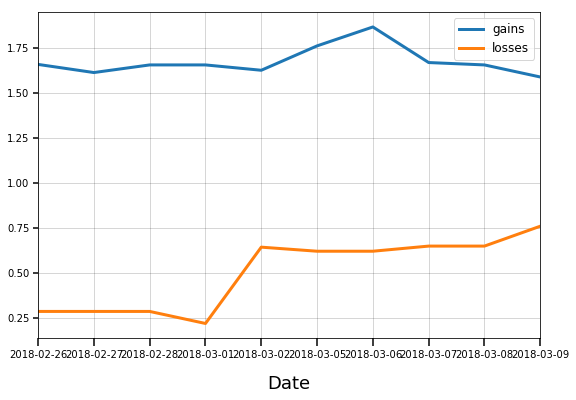

In [12]:
f,a = plt.subplots()
roll_up[-10:].plot(ax=a, label='gains', legend=True)
roll_down[-10:].plot(ax=a, label='losses', legend=True)

Calculate the $\text{RS}$ as the ratio of the moving averages

In [13]:
RS = roll_up / roll_down

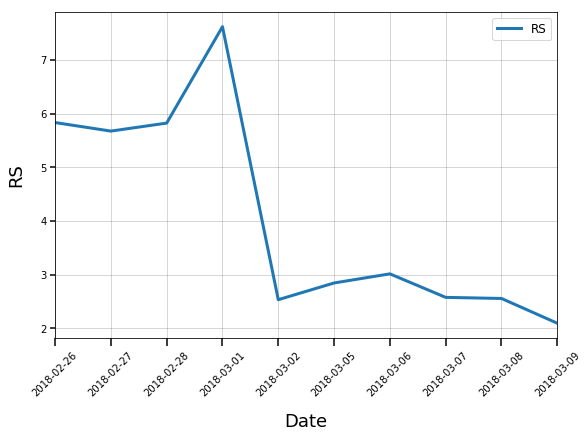

In [17]:
a = RS[-10:].plot(label='RS', legend=True, rot=45)
a.set_ylabel('RS')

Constructing $\text{RSI}$

In [15]:
RSI = 100.0 - (100.0 / (1.0 + RS))

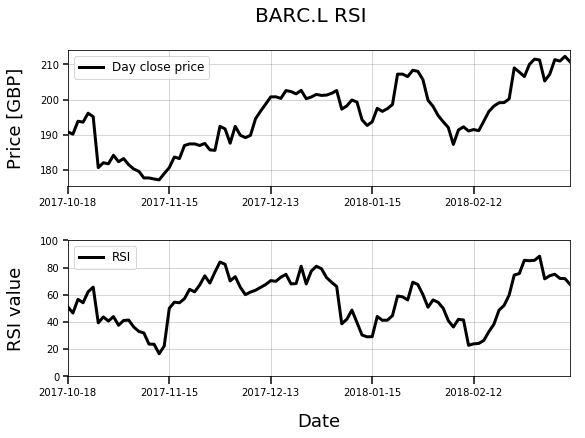

In [16]:
f,(a1,a2) = plt.subplots(nrows=2)
close[-100:].plot(ax=a1, c='k', label='Day close price', legend=True)
RSI[-100:].plot(ax=a2, c='k', label='RSI', legend=True)
a1.set_xlabel('')
a1.set_ylabel('Price [GBP]')
a2.set_ylim(0, 100)
a2.set_ylabel('RSI value')
title = security + " RSI"
f.suptitle(title)